In [1]:
from scipy.fft import fft, dct, idct, ifft
import numpy as np
import matplotlib.pyplot as plt
# import python_speech_features as spc
import thermocepstrum as tc
from scipy.signal import periodogram
#from scipy import fft
# import scipy._realtransforms as rfft
# from scipy import ifft
# from scipy.signal.windows import triang
from scipy.interpolate import interp1d as interpol
# from scipy.special import lambertw, gamma
# from scipy import fft.dct, fft.idct
#import scipy.fft.dct 


In [2]:
a = 1.0e12
def hz2mel(hz):
    """Convert a value in Hertz to Mels

    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
#     return a * np.log(1+hz/a)/np.log(2)
    return a / np.log(2) * np.log(1 + np.log(1+hz/a)/np.log(2))


def mel2hz(mel):
    """Convert a value in Mels to Hertz

    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
#     return a*(np.exp(np.log(2)*mel/(a))-1)
    return a * (np.exp(np.log(2) * (np.exp(mel*np.log(2)/a) - 1)) - 1)

def hz2mel_rec(hz, n=1):
    """Convert a value in Hertz to Mels

    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    x = np.copy(hz)
    for i in range(n):
        x = a * np.log(1+x/a)/np.log(2)
    return x 


def mel2hz_rec(mel, n=1):
    """Convert a value in Mels to Hertz

    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    x = np.copy(mel)
    for i in range(n):
        x = a*(np.exp(np.log(2)*x/(a))-1)
    return x

def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)

    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    #print('melpoints=',melpoints)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bins = np.floor(2*nfft*mel2hz(melpoints)/samplerate)
    
    fbank = np.zeros([nfilt, nfft])
    for j in range(0,nfilt):
        
        for i in range(int(bins[j]), int(bins[j+1])):
            fbank[j,i] = (i - bins[j]) / (bins[j+1]-bins[j])
        for i in range(int(bins[j+1]), int(bins[j+2])):
            fbank[j,i] = (bins[j+2]-i) / (bins[j+2]-bins[j+1])
        fbank[j,:] *= 2./(bins[j+2]-bins[j])    
    return fbank, melpoints

def mel_filter(arr, nfilt=20, samplerate=16000, lowfreq=0, highfreq=None, axis=0, nrec=1):
    
    dim = list(arr.shape)
    dim[axis] = nfilt+2
#     dim[axis] = nfilt
    
    out = np.zeros(tuple(dim)) #, dtype = np.complex)
    
    
    
    highfreq= highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel_rec(lowfreq, nrec)
    highmel = hz2mel_rec(highfreq, nrec)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    print('melpoints', melpoints)
    nfft = arr.shape[axis]
    print('mel2hz={}'.format(mel2hz_rec(melpoints, nrec)))
    bins = np.floor(2*nfft*mel2hz_rec(melpoints, nrec)/samplerate)
    print('bins=',bins)
    for j in range(0, nfilt):
        for i in range(int(bins[j]), int(bins[j+1])):
            fb = (i - bins[j]) / (bins[j+1]-bins[j])
#             out[j] += fb*(1+1j)*arr[i]
            out[j+1] += fb*arr[i]
            
        for i in range(int(bins[j+1]), int(bins[j+2])):
            fb = (bins[j+2]-i) / (bins[j+2]-bins[j+1])
#             out[j] += fb*(1+1j)*arr[i]
            out[j+1] += fb*arr[i]
            
#         out[j] *= 2./(bins[j+2]-bins[j])
        out[j+1] *= 2./(bins[j+2]-bins[j])
    out[0] = arr[0]              
    out[-1] = arr[int(bins[-1])] 

    return out, melpoints

# def to_filter(flux):
def _gamma_inverse(x):
    """
    Inverse the gamma function.
    http://mathoverflow.net/questions/12828/inverse-gamma-function
    """
    k=1.461632 # the positive zero of the digamma function, scipy.special.psi
#     assert x>=k, 'gamma(x) is strictly increasing for x >= k, k=%1.2f, x=%1.2f' % (k, x)
    C=np.sqrt(2*np.pi)/np.e - gamma(k) # approximately 0.036534
    L=np.log((x+C)/np.sqrt(2*np.pi))
    gamma_inv = 0.5+L/lambertw(L/np.e)
    return gamma_inv

In [3]:
#data=tc.i_o.read_lammps_log.LAMMPSLogFile(\
#                                           '/scratch/ppegolo/Li3ClO/DATA_ANAL_CLASS/flux.10ns.1.20.lammps',
#                                          '/u/p/ppegolo/Documents/PhD/simulations/Li3ClO/flux.10ns.1.20.lammps',
#                                          run_keyword="LEGGIMI")
#d=data.read_datalines(select_ckeys=['flux', 'jel', 'Temp'])

data=np.genfromtxt('./data/flux.10.dat',names=True,skip_header=1)
d={}
d['Time']=data['Time']
d['Temp']=data['Temp']
d['flux'] = np.column_stack((data['c_flux1'],data['c_flux2'],data['c_flux3']))
d['jel'] = np.column_stack((data['c_Jel1'],data['c_Jel2'],data['c_Jel3']))
vol = 59343.164 # Ang^3
#vol=tc.i_o.read_lammps_datafile.get_box(\
#                                         '/scratch/ppegolo/Li3ClO/DATA_ANAL_CLASS/structure.Li3ClO.10ns.1.20.lammps'
#                                        '/u/p/ppegolo/Documents/PhD/simulations/Li3ClO/structure.Li3ClO.10ns.1.20.lammps'\
#                                       )[-1]

In [4]:
d

{'Time': array([ 650.1  ,  650.105,  650.11 , ..., 1650.09 , 1650.095, 1650.1  ]),
 'Temp': array([296.68301, 295.57381, 295.18616, ..., 299.17062, 301.12103,
        300.03181]),
 'flux': array([[ 2774.3229 ,  -663.107  , -3429.2905 ],
        [ 3462.8204 ,  -780.02587, -3074.1353 ],
        [ 3983.5696 ,  -677.74059, -2338.3222 ],
        ...,
        [-1778.0449 , -3382.3613 ,  2108.2906 ],
        [-2506.4159 , -3513.5923 ,  2016.9767 ],
        [-3474.7929 , -3398.5946 ,  1981.9773 ]]),
 'jel': array([[ -46.343521, -836.86507 , -368.10682 ],
        [ 137.47146 , -844.40189 , -104.87439 ],
        [ 271.52109 , -743.66569 ,  227.01926 ],
        ...,
        [ 964.69077 , -135.53782 , -289.63532 ],
        [ 589.7173  , -132.61524 , -175.73089 ],
        [ 157.55378 ,  -67.461333,  -49.214231]])}

In [5]:
j = tc.HeatCurrent(j=[d['flux'], d['jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=500)
jlog = tc.HeatCurrent(j=[d['flux'], d['jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=500,mel_log_flag=True)

Using multicomponent code.
trajectory has an odd number of points. Removing the first one.
trajectory has an odd number of points. Removing the first one.
bins=[0.0000e+00 9.0000e+00 1.8000e+01 2.8000e+01 3.7000e+01 4.7000e+01
 5.6000e+01 6.6000e+01 7.6000e+01 8.6000e+01 9.6000e+01 1.0600e+02
 1.1600e+02 1.2700e+02 1.3700e+02 1.4800e+02 1.5800e+02 1.6900e+02
 1.8000e+02 1.9100e+02 2.0200e+02 2.1300e+02 2.2400e+02 2.3500e+02
 2.4700e+02 2.5800e+02 2.7000e+02 2.8200e+02 2.9400e+02 3.0600e+02
 3.1800e+02 3.3000e+02 3.4200e+02 3.5500e+02 3.6700e+02 3.8000e+02
 3.9300e+02 4.0600e+02 4.1900e+02 4.3200e+02 4.4500e+02 4.5800e+02
 4.7200e+02 4.8600e+02 4.9900e+02 5.1300e+02 5.2700e+02 5.4100e+02
 5.5600e+02 5.7000e+02 5.8500e+02 5.9900e+02 6.1400e+02 6.2900e+02
 6.4400e+02 6.5900e+02 6.7500e+02 6.9000e+02 7.0600e+02 7.2200e+02
 7.3700e+02 7.5400e+02 7.7000e+02 7.8600e+02 8.0300e+02 8.1900e+02
 8.3600e+02 8.5300e+02 8.7000e+02 8.8800e+02 9.0500e+02 9.2300e+02
 9.4100e+02 9.5900e+02 9.7700e+02 9.

In [6]:
#j10k = tc.HeatCurrent(j=[d['flux'], d['jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
#                  units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=10000)

In [7]:
#j50k = tc.HeatCurrent(j=[d['flux'], d['jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
#                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=50000)

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     100.00000 THz
 Resampling freq          f* =     100.00000 THz
 Sampling time         TSKIP =             1 steps
                             =         5.000 fs
 Original  n. of frequencies =        100001
 Resampled n. of frequencies =        100001
 PSD      @cutoff  (pre-filter) =    265.81295
                  (post-filter) =    265.81295
 log(PSD) @cutoff  (pre-filter) =      5.58206
                  (post-filter) =      5.58206
 min(PSD)          (pre-filter) =      7.09280
 min(PSD)         (post-filter) =      7.09280
 % of original PSD Power f<f* (pre-filter)  = 100.000000
-----------------------------------------------------



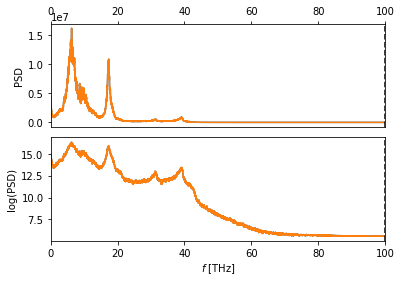

In [6]:
jf=j.resample_current(PSD_FILTER_W=0.1, fstar_THz=100)

In [7]:
j.mel_cepstral_analysis()
print('log mel-filter')
jlog.mel_cepstral_analysis()

-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 26  (P* = 27, corr_factor = 1.000000)
  L_0*   =          14.781348 +/-   0.261202
  S_0*   =     3442506.412754 +/- 899190.042169
-----------------------------------------------------
  Mel kappa* =           6.111266 +/-   0.000000  W/mK
-----------------------------------------------------

log mel-filter
-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 26  (P* = 27, corr_factor = 1.000000)
  L_0*   =          14.781348 +/-   0.261202
  S_0*   =     3442506.412754 +/- 899190.042169
-----------------------------------------------------
  Mel kappa* =           6.111266 +/-   0.000000  W/mK
-----------------------------------------------------



In [15]:
print(j.mel_psd_std[0]*502**2*j.kappa_scale/2.)

0.003620815814612046


In [26]:
j.compute_mel_filter(triang=False)

bins=[0.0000e+00 9.0000e+00 1.8000e+01 2.8000e+01 3.7000e+01 4.7000e+01
 5.6000e+01 6.6000e+01 7.6000e+01 8.6000e+01 9.6000e+01 1.0600e+02
 1.1600e+02 1.2700e+02 1.3700e+02 1.4800e+02 1.5800e+02 1.6900e+02
 1.8000e+02 1.9100e+02 2.0200e+02 2.1300e+02 2.2400e+02 2.3500e+02
 2.4700e+02 2.5800e+02 2.7000e+02 2.8200e+02 2.9400e+02 3.0600e+02
 3.1800e+02 3.3000e+02 3.4200e+02 3.5500e+02 3.6700e+02 3.8000e+02
 3.9300e+02 4.0600e+02 4.1900e+02 4.3200e+02 4.4500e+02 4.5800e+02
 4.7200e+02 4.8600e+02 4.9900e+02 5.1300e+02 5.2700e+02 5.4100e+02
 5.5600e+02 5.7000e+02 5.8500e+02 5.9900e+02 6.1400e+02 6.2900e+02
 6.4400e+02 6.5900e+02 6.7500e+02 6.9000e+02 7.0600e+02 7.2200e+02
 7.3700e+02 7.5400e+02 7.7000e+02 7.8600e+02 8.0300e+02 8.1900e+02
 8.3600e+02 8.5300e+02 8.7000e+02 8.8800e+02 9.0500e+02 9.2300e+02
 9.4100e+02 9.5900e+02 9.7700e+02 9.9500e+02 1.0130e+03 1.0320e+03
 1.0510e+03 1.0700e+03 1.0890e+03 1.1080e+03 1.1280e+03 1.1480e+03
 1.1670e+03 1.1880e+03 1.2080e+03 1.2280e+03 1.2490e+03 1

In [30]:
# jr=j.resample_current(fstar_THz=1.0)[0]
j.cepstral_analysis()

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 185  (P* = 186, corr_factor = 1.000000)
  L_0*   =          14.312387 +/-   0.048915
  S_0*   =     2927334.909999 +/- 143191.429833
-----------------------------------------------------
  kappa* =           5.196714 +/-   0.254199  W/mK
-----------------------------------------------------



In [43]:
#j10k.mel_cepstral_analysis()

-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 557  (P* = 558, corr_factor = 1.000000)
  L_0*   =          14.943622 +/-   0.026816
  S_0*   =     5503186.860271 +/- 147573.831169
-----------------------------------------------------
  Mel kappa* =          10.021012 +/-   0.268724  W/mK
-----------------------------------------------------



In [47]:
#j50k.mel_cepstral_analysis()

-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 349  (P* = 350, corr_factor = 1.000000)
  L_0*   =          14.731598 +/-   0.021232
  S_0*   =     4451777.790505 +/- 94521.308544
-----------------------------------------------------
  Mel kappa* =           8.106452 +/-   0.172118  W/mK
-----------------------------------------------------



In [26]:
jpsd_sq = np.copy(j.mel_dct.psd)

In [13]:
%matplotlib notebook
plt.plot(j.mel_filtered_freqs_THz, conv*(j.mel_dct.psd-jpsd_sq), label='tr')


NameError: name 'conv' is not defined

In [21]:
j.mel_cepstral_analysis()

ValueError: operands could not be broadcast together with shapes (100001,) (502,) 

<IPython.core.display.Javascript object>


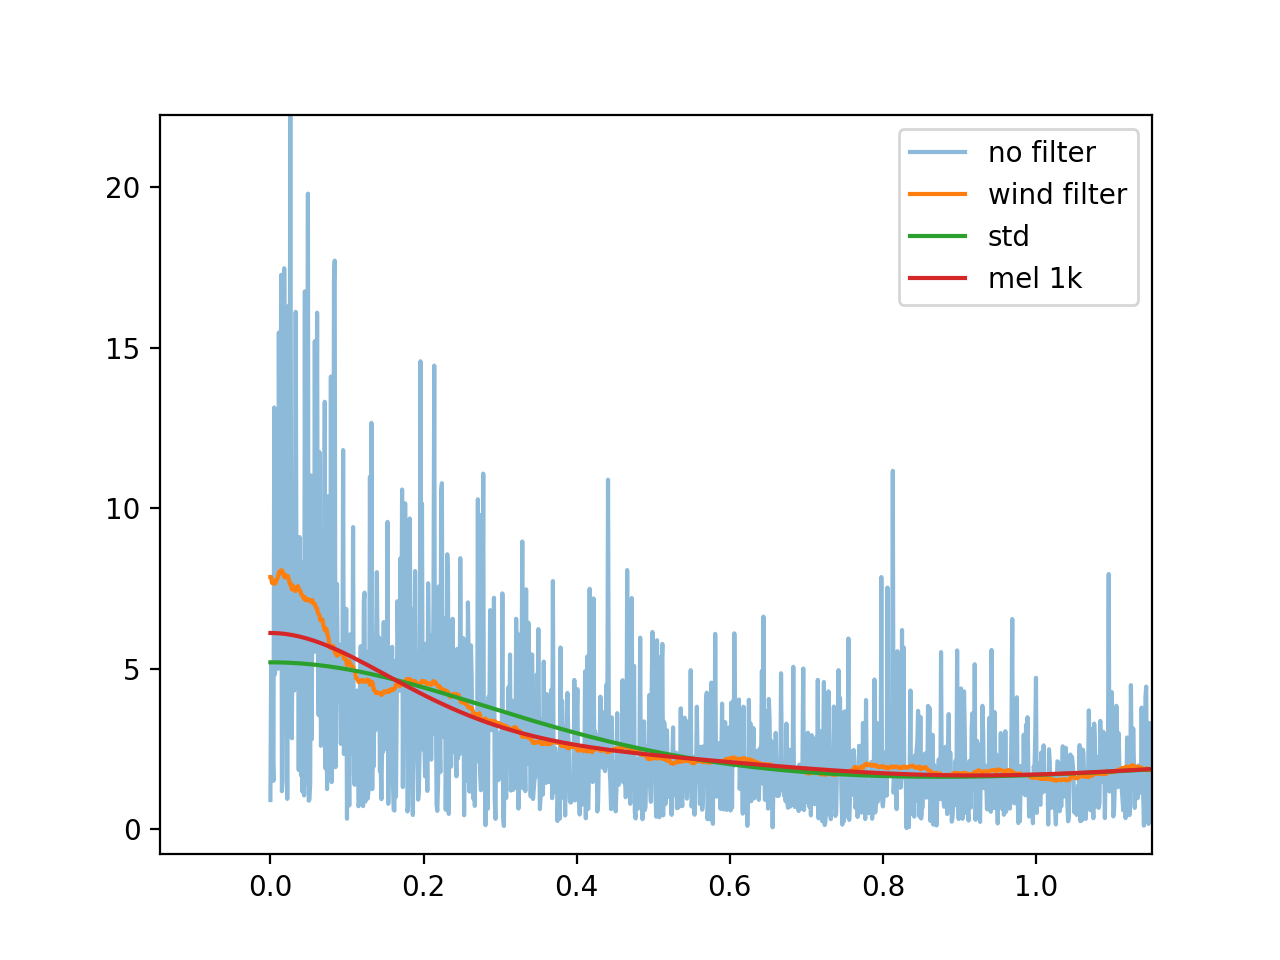

In [31]:
%matplotlib notebook
conv=j.kappa_scale/2
plt.plot(j.freqs_THz, j.psd*conv, label='no filter', alpha=0.5)
plt.plot(jf[0].freqs_THz, jf[0].fpsd*conv, label='wind filter')

plt.plot(j.freqs_THz, j.dct.psd*conv, label='std')
plt.plot(j.mel_filtered_freqs_THz, conv*j.mel_dct.psd, label='mel 1k')
#plt.plot(j.mel_filtered_freqs_THz, conv*j.mel_filtered_psd, label='psd mel 1k',alpha=0.6)
#plt.plot(jlog.mel_filtered_freqs_THz, conv*jlog.mel_dct.psd, label='logmel 1k')
#plt.plot(jlog.mel2hz_rec(jlog.mel_points,jlog.mel_nrecursion)*1e-12, conv*np.exp(jlog.mel_filtered),'o-', label='logmel points')
#plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*j10k.mel_dct.psd, label='mel 10k')
#plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*j50k.mel_dct.psd, label='mel 50k')


# plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*jpsd_sq, label='sq')

#plt.plot(jnewfull.freqs_THz,jnewfull.psd*conv, label='media a blocchi') #,marker=marker,ms=ms,lw=lw)
#plt.plot(jnewfull.freqs_THz,jnewfull.dct.psd*conv, label='media a blocchi cepstral') #,marker=marker,ms=ms,lw=lw)


plt.legend()

In [33]:
jlog.mel2hz_rec(jlog.mel_filtered,jlog.mel_nrecursion)

array([4.37627712, 4.66604533, 4.94937424, 4.7311044 , 4.83946216,
       5.12079268, 5.08926234, 5.1199045 , 5.11168885, 5.13478149,
       5.09703391, 4.95981034, 4.79039031, 4.98845409, 5.2309268 ,
       5.17319521, 4.87809793, 4.81437112, 5.24380539, 5.31241717,
       5.12434539, 5.00355313, 5.05573361, 5.05506748, 5.17674792,
       5.15343324, 4.92583752, 4.84834395, 4.83746376, 4.59254856,
       4.77062834, 4.96291896, 4.84634555, 4.90163465, 4.95536945,
       4.71844785, 4.70534722, 4.91318097, 4.99733588, 5.12279108,
       5.09525755, 5.14055465, 5.05151476, 5.03952435, 4.97335506,
       4.8216986 , 4.99955632, 4.99533748, 4.84123852, 4.8605564 ,
       5.11279907, 5.04352116, 4.89097651, 4.95781194, 5.05195885,
       4.98734387, 4.9924509 , 4.98889818, 4.89053242, 4.86655161,
       4.94337904, 4.86011231, 4.64983607, 4.68203254, 4.74065232,
       4.70912198, 4.8689941 , 4.76685358, 4.69535522, 4.86366503,
       4.60342875, 4.62963001, 4.84456919, 4.71289674, 4.69846

In [33]:
jene=d['flux']
jele=d['jel']
N=len(jene)
print('{} ps'.format(N*0.005))
n=100
print('{} subtrajs. of {} ps'.format(n, N//n*0.005))

bau=np.array([jc.reshape(n, N//n).T for jc in jene.T])
newjene=np.concatenate(bau.T, axis=1)

bau=np.array([jc.reshape(n, N//n).T for jc in jele.T])
newjele=np.concatenate(bau.T, axis=1)

10000.0 ps
100 subtrajs. of 100.0 ps


In [36]:
%matplotlib notebook

fstar=3.0
FILT=0.1

jnew = tc.HeatCurrent(j=[newjene, newjele], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']), units='metal', VOLUME=vol)
jnewfull = jnew.resample_current(fstar_THz=100, PSD_FILTER_W=FILT, plot=False)
jnewfull.compute_psd()
jnewfull.cepstral_analysis()
jnewfstar = jnew.resample_current(fstar_THz=fstar, PSD_FILTER_W=FILT, plot=False)
jnewfstar.compute_psd()
jnewfstar.cepstral_analysis()
conv=jnewfstar.kappa_scale/2

marker='o'
ms=2
lw=0.5

Using multicomponent code.
Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     100.00000 THz
 Resampling freq          f* =     100.00000 THz
 Sampling time         TSKIP =             1 steps
                             =         5.000 fs
 Original  n. of frequencies =         10001
 Resampled n. of frequencies =         10001
 fPSD not calculated before resampling!
 -----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 556  (P* = 557, corr_factor = 1.000000)
  L_0*   =          15.261427 +/-   0.019310
  S_0*   =     4259978.853891 +/- 82258.853977
-----------------------------------------------------
  kappa* =           7.757196 +/-   0.149789  W/mK
-----------------------------------------------------

In [ ]:
jnewfull.